<a href="https://colab.research.google.com/github/amirrezavelae/Reinforcement-Learning/blob/main/HW/HW4/rl_hw4_(1)%20(5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Offline RL (80 Points)

> Name: Amirreza Velae

> SID: 400102222




In this notebook, we will implement the Soft Actor Critic (SAC) algorithm on the CartPole environment in both online and offline settings. The SAC framework focuses on maximizing the expected reward while also maximizing entropy, meaning the actor aims to succeed at the task while maintaining a high level of randomness in its actions. This approach explicitly encourages exploration by seeking a high entropy in the policy.

In the second part, we will use the policy learned in the first part to collect a dataset of expert trajectories and perform behavioral cloning.

*The existing results are the baseline for the quality of your implementation.*

In [ ]:
!pip -q install imageio==2.19.3
!pip -q install imageio-ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 15.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Network Structure (10 points)
For constructing SAC agent, we use objects of feedforward neural networks with 3 layers. Complete the code below.

In [ ]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        ##########################################################
        # TODO
        self.fc1 = nn.Linear(input_dimension,64)
        self.fc2 = nn.Linear(64,128)
        self.fc3 = nn.Linear(128,output_dimension)
        self.output_activation = output_activation
        ##########################################################

    def forward(self, inpt):
        output = None
        ##########################################################
        # TODO
        output = torch.relu(self.fc1(inpt))
        output = torch.relu(self.fc2(output))
        output = self.output_activation(self.fc3(output))
        ##########################################################

        return output

## Replay Buffer

A SAC agent requires a replay buffer to sample previously visited states. You can utilize the implemented code below to set up this replay buffer.

In [ ]:
import numpy as np


class ReplayBuffer:

    def __init__(self, environment, capacity=500000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 1e-2
        self.delta = 1e-4
        self.indices = None
        self.mirror_index = np.random.permutation(range(self.buffer.shape[0]))

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, bool'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100, batch_deterministic_start=None):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        if batch_deterministic_start is None:
            self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        else:
            self.indices = self.mirror_index[batch_deterministic_start:batch_deterministic_start+size]
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count

## SAC Agent (50 points)

Now complete the following class. You can use the auxiliary methods provided in the class.

In [74]:
class SACAgent:
  def __init__(self, environment, replay_buffer=None, offline=False, learning_rate=3e-4, discount=0.99, buffer_batch_size=100, alpha_init=1, interpolation_factor=0.01, device= 'cpu', update_we = False):
    self.environment = environment
    self.state_dim = self.environment.observation_space.shape[0]
    self.action_dim = self.environment.action_space.n
    self.device = device
    self.alpha_init = alpha_init
    self.learning_rate = learning_rate
    self.actor_lr = learning_rate*3/10
    self.discount = discount
    self.buffer_batch_size = buffer_batch_size
    self.interpolation_factor = interpolation_factor

    self.replay_buffer = ReplayBuffer(self.environment) if replay_buffer is None else replay_buffer
    self.offline = offline

    self.update_we = update_we

    ##########################################################
    # TODO
    # Define critics usig your implemented feed forward netwrok
    ##########################################################
    self.critic_local = Network(self.state_dim, self.action_dim).to(device)
    self.critic_local2 = Network(self.state_dim, self.action_dim).to(device)
    self.critic_optimiser = optim.Adam(self.critic_local.parameters(), lr=self.learning_rate)
    self.critic_optimiser2 = optim.Adam(self.critic_local2.parameters(), lr=self.learning_rate)
    self.critic_target = Network(self.state_dim, self.action_dim).to(device)
    self.critic_target2 = Network(self.state_dim, self.action_dim).to(device)
    ##########################################################

    self.soft_update_target_networks(tau=1.)

    ##########################################################
    # TODO
    # Define the actor
    # Define the actor optimizer
    ##########################################################
    self.actor_local = Network(self.state_dim, self.action_dim, output_activation=torch.nn.Softmax(dim=1)).to(device)
    self.actor_optimiser  = optim.Adam(self.actor_local.parameters(), lr=self.actor_lr)
    ##########################################################
    self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
    self.log_alpha = torch.tensor(np.log(self.alpha_init), requires_grad=True)
    self.alpha = self.log_alpha
    self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=self.learning_rate)

  def get_next_action(self, state, evaluation_episode=False):
    if evaluation_episode:
        discrete_action = self.get_action_deterministically(state)
    else:
        discrete_action = self.get_action_nondeterministically(state)
    return discrete_action

  def get_action_nondeterministically(self, state):
    action_probabilities = self.get_action_probabilities(state)
    discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
    return discrete_action

  def get_action_deterministically(self, state):
    action_probabilities = self.get_action_probabilities(state)
    discrete_action = np.argmax(action_probabilities)
    return discrete_action

  def critic_loss(self, states_tensor, actions_tensor, rewards_tensor,
                  next_states_tensor, done_tensor):
    ##########################################################
    # TODO
    # You are going to calculate critic losses in this method
    ##########################################################
    with torch.no_grad():
      next_actions, log_action_probabilities = self.get_action_info(next_states_tensor)
      next_q_values = self.predict_next_q_values(next_states_tensor)
      soft_Values = torch.sum(next_actions * (next_q_values - self.alpha * log_action_probabilities), dim=1)
      target_q_values = rewards_tensor + self.discount * (~done_tensor) * soft_Values

    q_values = self.critic_local(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
    q_values2 = self.critic_local2(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
    critic_loss = F.mse_loss(q_values, target_q_values)
    critic2_loss = F.mse_loss(q_values2, target_q_values)
    return critic_loss, critic2_loss
      ##########################################################

  def actor_loss(self, states_tensor):
    ##########################################################
    # TODO
    # Implement the actor loss
    next_actions, log_action_probabilities = self.get_action_info(states_tensor)
    q_values = self.predict_q_values(states_tensor)
    actor_loss = torch.sum(next_actions * (self.alpha * log_action_probabilities - q_values)).mean()
    ##########################################################
    return actor_loss, log_action_probabilities
    ##########################################################

  def train_on_transition(self, state, discrete_action, next_state, reward, done):
    transition = (state, discrete_action, reward, next_state, done)
    self.train_networks(transition)

  def train_networks(self, transition=None, batch_deterministic_start=None):
    ##########################################################
    # TODO
    # Set all the gradients stored in the optimizers to zero
    # Add the new transition to the replay buffer for online case
    ##########################################################
    self.critic_optimiser.zero_grad()
    self.critic_optimiser2.zero_grad()
    self.actor_optimiser.zero_grad()
    self.alpha_optimiser.zero_grad()

    if not self.offline:
        self.replay_buffer.add_transition(transition)
    if self.replay_buffer.get_size() >= self.buffer_batch_size:
      minibatch = self.replay_buffer.sample_minibatch(self.buffer_batch_size, batch_deterministic_start=batch_deterministic_start)
      minibatch_separated = list(map(list, zip(*minibatch)))

      states_tensor = torch.tensor(np.array(minibatch_separated[0])).to(self.device)
      actions_tensor = torch.tensor(np.array(minibatch_separated[1])).to(self.device)
      rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float().to(self.device)
      next_states_tensor = torch.tensor(np.array(minibatch_separated[3])).to(self.device)
      done_tensor = torch.tensor(np.array(minibatch_separated[4])).to(self.device)

      ##########################################################
      # TODO
      # compute the critic loss and perform the backpropagation,
      critic_loss, critic2_loss = self.critic_loss(states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor)
      critic_loss.backward()
      critic2_loss.backward()
      self.critic_optimiser.step()
      self.critic_optimiser2.step()
      # then compute the actor loss and backpropagate the gradient on it
      actor_loss, log_action_probabilities = self.actor_loss(states_tensor)
      actor_loss.backward()
      self.actor_optimiser.step()
      # You also need to update \alpha
      alpha_loss = self.temperature_loss(log_action_probabilities)
      alpha_loss.backward()
      self.alpha_optimiser.step()
      ##########################################################

      # update the weights in the replay buffer to learn on data wich are causing more loss
      if self.update_we:
        updated_buffer_weights = [
            min(loss1.item(), loss2.item()) for loss1, loss2
            in zip(critic_loss.unsqueeze(-1), critic2_loss.unsqueeze(-1))
        ]
        self.replay_buffer.update_weights(updated_buffer_weights)

      self.soft_update_target_networks(self.interpolation_factor)

  def temperature_loss(self, log_action_probabilities):
    alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
    return alpha_loss

  def get_action_info(self, states_tensor):
    action_probabilities = self.actor_local.forward(states_tensor)
    z = action_probabilities == 0.0
    z = z.float() * 1e-8
    log_action_probabilities = torch.log(action_probabilities + z)
    return action_probabilities, log_action_probabilities

  def get_action_probabilities(self, state):
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
    action_probabilities = self.actor_local.forward(state_tensor).to("cpu")
    return action_probabilities.squeeze(0).detach().numpy()

  def soft_update_target_networks(self, tau):
    self.soft_update(self.critic_target, self.critic_local, tau)
    self.soft_update(self.critic_target2, self.critic_local2, tau)

  def soft_update(self, target_model, origin_model, tau):
    for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
        target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

  def predict_next_q_values(self, state):
    q_values = self.critic_target(state)
    q_values2 = self.critic_target2(state)
    return torch.min(q_values, q_values2)

  def predict_q_values(self, state):
    q_values = self.critic_local(state)
    q_values2 = self.critic_local2(state)
    return torch.min(q_values, q_values2)

## Online SAC (10 points)

Now evaluate your model in CartPole environment in the online setting. After each 4 episodes, you should evaluate your model on a separate test environment. Run your model 4 times separately and plot the mean and deviation of the evaluation curves.

**NOTE:** Since you are going to use the replay buffer of this agent as the offline dataset, you may want to save it for later use.

In [ ]:
def train_sac_agent(env, agent, replay_buffer, episodes_per_run, steps_per_episode, training_evaluation_ratio):
    results = []
    for episode in tqdm(range(episodes_per_run), desc='Training Episodes'):
        evaluate = episode % training_evaluation_ratio == 0
        running_reward = 0
        state = env.reset()
        done = False

        for step in range(steps_per_episode):
            if done:
                break

            action = agent.get_next_action(state, evaluate)
            next_state, reward, done, _ = env.step(action)

            replay_buffer.add_transition((state, action, reward, next_state, done))

            if evaluate:
                running_reward += reward
            else:
                agent.train_on_transition(state, action, next_state, reward, done)
            state = next_state

        if evaluate:
            results.append(running_reward)
    return results

In [ ]:
import jax.dlpack
TRAINING_EVALUATION_RATIO = 4
EPISODES_PER_RUN = 500
STEPS_PER_EPISODE = 200
env = gym.make("CartPole-v1")

##########################################################
# TODO
# Implement the training loop for the online SAC.
# After each epoch, run validation
# and plot the mean return over these
# episodes in the end
# Plot the learning curves
##########################################################
replay_buffer = ReplayBuffer(env)
agents_results = []

for run in range(4):
    agent = SACAgent(env, device = "cpu")
    result_agent = train_sac_agent(env, agent, replay_buffer, EPISODES_PER_RUN, STEPS_PER_EPISODE, TRAINING_EVALUATION_RATIO)
    agents_results.append(result_agent)
    print("mean reward : {}".format(np.mean(agents_results)))

env.close()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
Training Episodes: 100%|██████████| 500/500 [18:55<00:00,  2.27s/it]


mean reward : 168.952


Training Episodes: 100%|██████████| 500/500 [19:38<00:00,  2.36s/it]


mean reward : 171.252


Training Episodes: 100%|██████████| 500/500 [17:32<00:00,  2.11s/it]


mean reward : 167.86933333333334


Training Episodes: 100%|██████████| 500/500 [19:18<00:00,  2.32s/it]

mean reward : 168.352


In [ ]:
print('Number of batches: ',replay_buffer.get_size() // EPISODES_PER_RUN)

Number of batches:  674


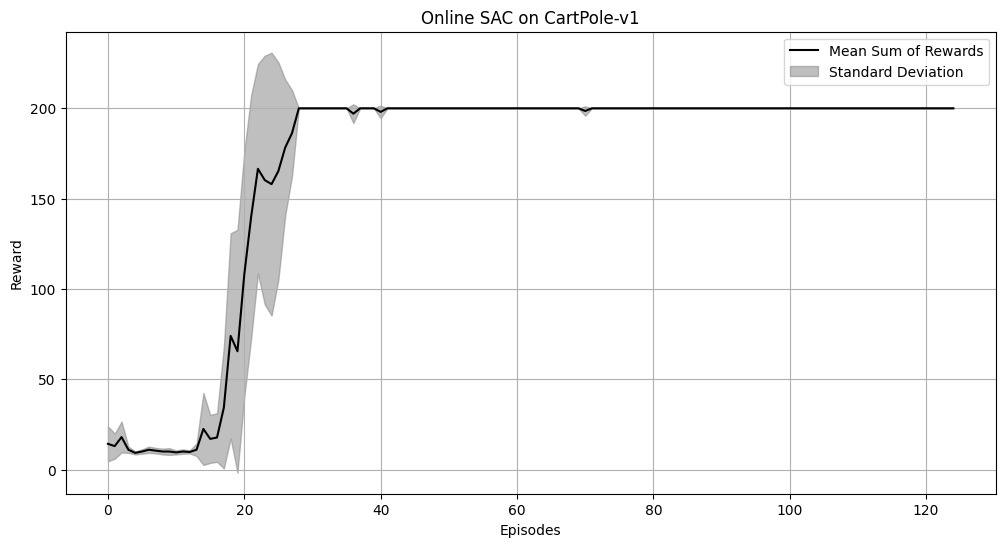

In [ ]:
episodes = np.arange(len(agents_results[0]))

mean_values = np.mean(agents_results, axis=0)
std_values = np.std(agents_results, axis=0)

plt.figure(figsize=(12, 6))
plt.plot(episodes, mean_values, label='Mean Sum of Rewards', color='k')
plt.fill_between(episodes, mean_values - std_values, mean_values + std_values,
                 color='gray', alpha=0.5, label='Standard Deviation')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Online SAC on CartPole-v1')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state = env.reset()
for _ in range(100):
    # state = torch.tensor(state).unsqueeze(0)
    frames.append(env.render()[0])
    action = agent.get_next_action(state, evaluation_episode=True)
    state, reward, done, info = env.step(action)
    if done:
        break


env.close()
imageio.mimsave('./online.mp4', frames, fps=25)
show_video('./online.mp4')

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


## Offline SAC (10 points)

In this part you are going to train an SAC agent using the replay buffer from the online agent. During training you sample from this replay buffer and train the offline agent **without adding transitions to the replay buffer**. The loss function and every thing else is the same as the online setting.

In [91]:
NUM_EPOCHS = 200
EPISODES_PER_RUN = 500
VALIDATION_EPISODES = 5

env = gym.make("CartPole-v1")
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
##########################################################
# TODO
# Implement the training loop for the offline SAC.
# After each epoch, run  validation
# and plot the mean return over these
# episodes in the end
##########################################################
agent = SACAgent(env, replay_buffer=replay_buffer, offline=True, device=device, buffer_batch_size=2**15)
returns = []

for epoch in range(NUM_EPOCHS):
    agent.train_networks()

    # Validation phase
    total_rewards = []
    for _ in range(VALIDATION_EPISODES):
        state = env.reset()
        episode_reward = 0
        done = False

        for step in range(STEPS_PER_EPISODE):
            if done:
                break

            action = agent.get_next_action(state, evaluation_episode=True)
            state, reward, done, _= env.step(action)
            episode_reward += reward

        total_rewards.append(episode_reward)

    # Calculate and record validation results
    mean_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    returns.append((mean_reward))
    if epoch % 10 == 0:
      print(f'Epoch: {epoch + 1}, Mean Reward: {mean_reward}, Std Reward: {std_reward}')


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Epoch: 1, Mean Reward: 15.0, Std Reward: 4.147288270665544
Epoch: 11, Mean Reward: 9.4, Std Reward: 0.4898979485566356
Epoch: 21, Mean Reward: 9.4, Std Reward: 0.7999999999999999
Epoch: 31, Mean Reward: 9.2, Std Reward: 0.7483314773547882
Epoch: 41, Mean Reward: 9.0, Std Reward: 0.8944271909999159
Epoch: 51, Mean Reward: 9.4, Std Reward: 0.7999999999999999
Epoch: 61, Mean Reward: 9.4, Std Reward: 0.4898979485566356
Epoch: 71, Mean Reward: 10.0, Std Reward: 0.6324555320336759
Epoch: 81, Mean Reward: 9.2, Std Reward: 0.39999999999999997
Epoch: 91, Mean Reward: 11.4, Std Reward: 0.7999999999999999
Epoch: 101, Mean Reward: 20.8, Std Reward: 4.261455150532504
Epoch: 111, Mean Reward: 57.6, Std Reward: 15.47384890710776
Epoch: 121, Mean Reward: 30.2, Std Reward: 3.4292856398964493
Epoch: 131, Mean Reward: 21.8, Std Reward: 2.993325909419153
Epoch: 141, Mean Reward: 15.2, Std Reward: 2.039607805437114
Epoch: 151, Mean Reward: 11.2, Std Reward: 1.16619037896906
Epoch: 161, Mean Reward: 9.0, St

In [90]:
print(np.sum(replay_buffer.weights <= 1e-3))
print(replay_buffer.weights[-1])
print(replay_buffer.get_size())

42820
0.47876474261283875
337047


### So there is a bug in replay buffer, that every time I update the weights, it sums a $\delta = 10^{-4}$ with any <font color='red'>all zero</font> transition which has <font color='red'>no</font> training gain.

In [92]:
# reset weights
replay_buffer.weights = np.zeros(replay_buffer.capacity)

## Solutions may consider updaiting replay buffer weights less often, lowering $\delta$ or training on whole dataset.

In [ ]:
NUM_EPOCHS = 200
EPISODES_PER_RUN = 500
VALIDATION_EPISODES = 5

env = gym.make("CartPole-v1")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
##########################################################
# TODO
# Implement the training loop for the offline SAC.
# After each epoch, run  validation
# and plot the mean return over these
# episodes in the end
##########################################################
agent = SACAgent(env, replay_buffer=replay_buffer, offline=True, device=device, buffer_batch_size=2**7)
returns = []

for epoch in range(NUM_EPOCHS):
    # Train the agent using data from the replay buffer
    # I tried training on some sample batches, turns out there is massive bias and
    # 200 epochs is not enough (makes absloutly sence). but here was the idea of training
    # on whole of it which worked but cost me an all-nighter.
    num_training_batches = agent.replay_buffer.get_size() // EPISODES_PER_RUN
    for i in range(num_training_batches):
        start_idx = i * EPISODES_PER_RUN
        agent.train_networks(batch_deterministic_start=start_idx)

    # Validation phase
    total_rewards = []
    for _ in range(VALIDATION_EPISODES):
        state = env.reset()
        episode_reward = 0
        done = False

        for step in range(STEPS_PER_EPISODE):
            if done:
                break

            action = agent.get_next_action(state, evaluation_episode=True)
            state, reward, done, _ = env.step(action)
            episode_reward += reward

        total_rewards.append(episode_reward)

    # Calculate and record validation results
    mean_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    returns.append((mean_reward))
    if epoch % 5 == 0:
      print(f'Epoch: {epoch + 1}, Mean Reward: {mean_reward}, Std Reward: {std_reward}')


Epoch: 1, Mean Reward: 9.2, Std Reward: 0.7483314773547882
Epoch: 6, Mean Reward: 55.6, Std Reward: 9.350935782048769
Epoch: 11, Mean Reward: 200.0, Std Reward: 0.0
Epoch: 16, Mean Reward: 183.0, Std Reward: 23.65586608010791
Epoch: 21, Mean Reward: 145.8, Std Reward: 44.41801436354399
Epoch: 26, Mean Reward: 135.8, Std Reward: 8.863407922464134
Epoch: 31, Mean Reward: 156.0, Std Reward: 15.811388300841896
Epoch: 36, Mean Reward: 188.6, Std Reward: 4.498888751680797
Epoch: 41, Mean Reward: 200.0, Std Reward: 0.0
Epoch: 46, Mean Reward: 200.0, Std Reward: 0.0
Epoch: 51, Mean Reward: 196.4, Std Reward: 7.2
Epoch: 56, Mean Reward: 200.0, Std Reward: 0.0
Epoch: 61, Mean Reward: 200.0, Std Reward: 0.0
Epoch: 66, Mean Reward: 200.0, Std Reward: 0.0
Epoch: 71, Mean Reward: 200.0, Std Reward: 0.0
Epoch: 76, Mean Reward: 200.0, Std Reward: 0.0
Epoch: 81, Mean Reward: 200.0, Std Reward: 0.0
Epoch: 86, Mean Reward: 200.0, Std Reward: 0.0
Epoch: 91, Mean Reward: 200.0, Std Reward: 0.0
Epoch: 96, M

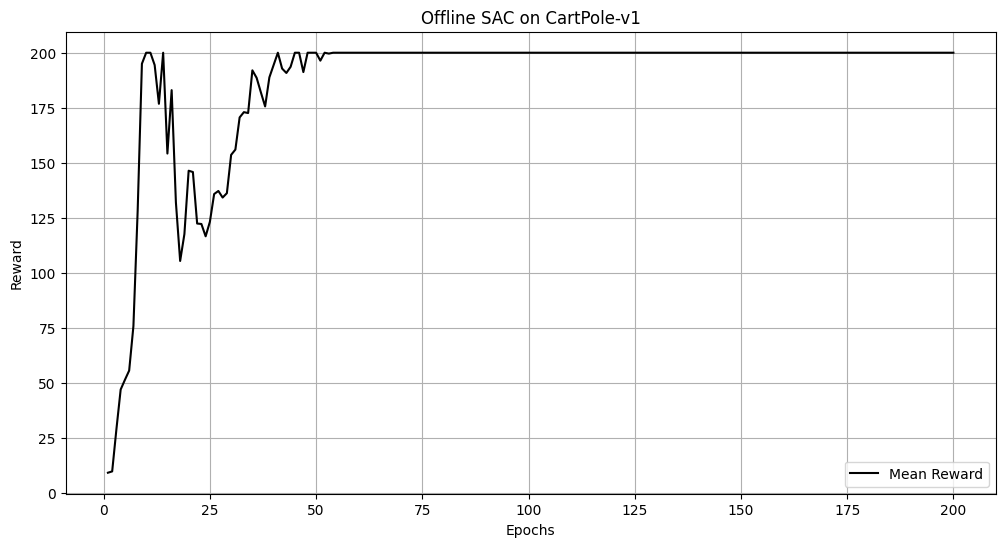

In [ ]:
epochs = range(1, len(returns) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, returns, label='Mean Reward', color='black')
plt.xlabel('Epochs')
plt.ylabel('Reward')
plt.title('Offline SAC on CartPole-v1')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state = env.reset()
for _ in range(100):
    frames.append(env.render()[0])
    action = agent.get_next_action(state, evaluation_episode=True)
    state, reward, done, info = env.step(action)
    if done:
        break
env.close()
imageio.mimsave('./offline.mp4', frames, fps=25)
show_video('./offline.mp4')

In [ ]:
with open('agent.pkl', 'wb') as file:
    pickle.dump(agent, file)

 # Behavioural Cloning (20 points)

Behavioral cloning works by mimicking expert behavior through supervised learning. It involves collecting a dataset of expert trajectories, which are sequences of state-action pairs (unlike offline reinforcement learning, which also collects rewards to train the model). The model is then trained to predict the expert's actions based on the observed states. The goal is for the model to replicate the expert's behavior by minimizing the difference between its predicted actions and the expert's actions.

We first need to collect data using the previously trained model.

In [ ]:
env = gym.make('CartPole-v1')
num_episodes = 1000
expert_data = []

# TODO
# Collect state-action pairs
for _ in range(num_episodes):
    state = env.reset()
    done = False
    while not done:
        action = agent.get_next_action(state, evaluation_episode=True)
        next_state, reward, done, _ = env.step(action)
        expert_data.append((state, action))
        state = next_state

states, actions = zip(*expert_data)
states = np.array(states)
actions = np.array(actions)

states_tensor = torch.tensor(states, dtype=torch.float32)
actions_tensor = torch.tensor(actions, dtype=torch.int64)

In [ ]:
print(states_tensor.shape)

torch.Size([499504, 4])


Define the model for behaviuoral cloning.

In [ ]:
class BCModel(nn.Module):
    def __init__(self, input_dimension, hidden_dimension, output_dimension):
        super(BCModel, self).__init__()
        # TODO
        # Define the model
        hidden_dimension1 = hidden_dimension*2
        hidden_dimension2 = hidden_dimension
        self.fc1 = nn.Linear(input_dimension, hidden_dimension1)
        self.fc2 = nn.Linear(hidden_dimension1, hidden_dimension2)
        self.fc3 = nn.Linear(hidden_dimension2, output_dimension)

    def forward(self, x):
        # TODO
        # Perform forward pass
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        output = self.fc3(x)
        return output

In this section, we implement the training loop for behavioral cloning. During each iteration, we sample a minibatch of state-action pairs from the expert dataset. This minibatch is then used to update the model.

In [ ]:
bc_model = BCModel(env.observation_space.shape[0], 64, env.action_space.n)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bc_model.parameters(), lr=1e-3)

num_epochs = 15
batch_size = 64

num_training_batches = len(expert_data) // batch_size

for epoch in range(num_epochs):
  total_loss = 0
  # TODO
  # Implement behavioural cloning training loop
  for i in range(num_training_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    states_batch = states_tensor[start_idx:end_idx]
    actions_batch = actions_tensor[start_idx:end_idx]
    optimizer.zero_grad()
    output = bc_model(states_batch)
    loss = criterion(output, actions_batch)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}')

Epoch 1/15, Loss: 1520.6781954730395
Epoch 2/15, Loss: 974.1399463982088
Epoch 3/15, Loss: 889.4929268824635
Epoch 4/15, Loss: 796.3584466506145
Epoch 5/15, Loss: 686.411839272012
Epoch 6/15, Loss: 609.0962270486634
Epoch 7/15, Loss: 566.0849508729007
Epoch 8/15, Loss: 517.0156955561761
Epoch 9/15, Loss: 482.43003192677315
Epoch 10/15, Loss: 448.02989144825074
Epoch 11/15, Loss: 427.81974108576736
Epoch 12/15, Loss: 408.8239830394077
Epoch 13/15, Loss: 396.56855085943425
Epoch 14/15, Loss: 381.3696317272488
Epoch 15/15, Loss: 370.70512913424045


Evaluate and render the results.

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state = env.reset()
for _ in range(100):
    frames.append(env.render()[0])
    state = torch.tensor(state).unsqueeze(0)
    action = torch.argmax(bc_model(state)).item()
    state, reward, done, _ = env.step(action)
    if done:
        break
env.close()
imageio.mimsave('./bc.mp4', frames, fps=25)
show_video('./bc.mp4')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely 